In [1]:
import pickle
import numpy as np
import pandas as pd
from keras.models import load_model
from jamotools import Vectorizationer, rules
from unicodedata import normalize
from IPython.display import Image, Audio

In [2]:
# validate the model on various phonological phenomena

In [3]:
# first load the model
# NOTE: load_model() loads a fully compiled model identical to the one saved using .save()

In [4]:
model = load_model("pronunciation_prediction.h5")

In [5]:
# load the reference DataFrame to ensure that the model wasn't trained on the entries it's being given for evaluation

In [6]:
ref = pd.read_csv("reference_all.csv", sep="\t")
ref.head()

,entry_id,word_id,spelling,pronunciation
0,13943,역사학,역사학,역싸학
1,13943,역사학,역사학이,역싸하기
2,13943,역사학,역사학도,역싸학또
3,13943,역사학,역사학만,역싸항만
4,13957,시대적2,시대적,시대적


In [7]:
# only the spelling column is needed, and store as a set since sets (and dicts) are implemented as hash tables underneath;
# additionally, using a set will remove duplicates from the spelling column created when alternative pronunciations were
# added (e.g., spellings with multiple pronunciations delimited by forward slashes and split during preprocessing)

In [8]:
ref[ref.duplicated(subset="spelling")].head()

,entry_id,word_id,spelling,pronunciation
5,13958,시대적1,시대적,시대적
65,13998,신기하다2,신기하다,신기하다
66,13998,신기하다2,신기한,신기한
67,13998,신기하다2,신기하여,신기하여
68,13998,신기하다2,신기해,신기해


In [9]:
ref[ref.spelling == "시대적"]

,entry_id,word_id,spelling,pronunciation
4,13957,시대적2,시대적,시대적
5,13958,시대적1,시대적,시대적


In [10]:
training_set = set(ref.spelling)

In [11]:
# instantiate the vectorizer for decoding predictions

In [12]:
vec = Vectorizationer(rule=rules.RULE_1, max_length=None)

In [13]:
# define a function for unvectorizing predictions

In [14]:
decoder = {v: k for k, v in vec.symbol_map.items()}

def unvectorize_norm_pad(vector):
    temp_list = [decoder[num] for num in vector if num != 0]
    temp_string = "".join(temp_list)
    return normalize("NFC", temp_string)

In [15]:
# define global variables for cumulative totals when calculating accuracy of model
cum_perfect_correct = 0
cum_syllables_correct = 0
cum_segments_correct = 0
cum_words_considered = 0
cum_syllables_considered = 0
cum_segments_considered = 0

In [16]:
# define a function for comparing items

In [17]:
longest_string = 23

def validate_model(phenomena, training_set=training_set, skip_training_data=True):
    
    print("   {:18} {:15} {:15} {:20}".format("IPA", "Spelling", "Pronunciation", "Predicted Pronunciation"))
    
    # indicate that these variables used below are their global counterparts and not local variables
    global cum_perfect_correct
    global cum_syllables_correct
    global cum_segments_correct
    global cum_words_considered
    global cum_syllables_considered
    global cum_segments_considered
    
    perfect_correct = 0
    syllables_correct = 0
    segments_correct = 0
    skipped_words = 0
    total_words = len(phenomena)
    syllables_considered = 0
    segments_considered = 0
    
    for instance in phenomena:
        spelling = instance[0]
        pronunciation = instance[1]
        ipa = instance[2]
        
        if skip_training_data and spelling in training_set:
            print()
            print(f"{spelling} was in the training set. skipping.")
            print()
            skipped_words += 1
            continue
        
        spell_vec = vec.vectorize(spelling)
        
        zeros_to_pad = longest_string - len(spell_vec)
        
        spell_padded = np.pad(spell_vec, (0, zeros_to_pad), "constant")

        spell_padded = spell_padded.reshape(1, spell_padded.shape[0])
        
        prediction = model.predict(spell_padded)[0].argmax(axis=1)
        
        predicted_pronunciation = unvectorize_norm_pad(prediction)
        
        image = "☒"
        
        num_syllables = len(pronunciation)
        syllables_considered += num_syllables
        
        # "NFD" produces a canonical decomposition, i.e., decomposes each syllable into its constituent segments 
        decomposed_pronunciation = normalize("NFD", pronunciation)
        segments_considered += len(decomposed_pronunciation)
        
        
        if pronunciation == predicted_pronunciation:
            perfect_correct += 1
            syllables_correct += num_syllables
            segments_correct += len(decomposed_pronunciation)
            image = "☑"
        else:
            # NOTE: zip will return an iterator of tuples whose number is equal to the number of syllables
            #       in the shortest string
            for syllable in zip(pronunciation, predicted_pronunciation):
                if syllable[0] == syllable[1]:
                    syllables_correct += 1
                    
            decomposed_predicted_pronunciation = normalize("NFD", predicted_pronunciation)
            
            for segment in zip(decomposed_pronunciation, decomposed_predicted_pronunciation):
                if segment[0] == segment[1]:
                    segments_correct += 1
                    
        
        justification = 16 + len(predicted_pronunciation) - len(pronunciation)*2
        print("{} {:20} {:10} {:>5} {}".format(image, ipa, spelling, pronunciation, 
                                               predicted_pronunciation.rjust(justification)))
        
        
    cum_perfect_correct += perfect_correct
    cum_syllables_correct += syllables_correct
    cum_segments_correct += segments_correct
    cum_words_considered += (total_words-skipped_words)
    cum_syllables_considered += syllables_considered
    cum_segments_considered += segments_considered        
    
    print()
    print("This Data:")
    print("Perfect Accuracy:       {:10.2f}%".format(100 * perfect_correct/(total_words-skipped_words)))
    print("Syllable Accuracy:      {:10.2f}%".format(100 * syllables_correct/syllables_considered))
    print("Segment (Letter) Accuracy:   {:5.2f}%".format(100* segments_correct/segments_considered))
    
    print()
    print("Cumulative:")
    print("Perfect Accuracy:       {:10.2f}%".format(100 * cum_perfect_correct/cum_words_considered))
    print("Syllable Accuracy:      {:10.2f}%".format(100 * cum_syllables_correct/cum_syllables_considered))
    print("Segment (Letter) Accuracy:   {:5.2f}%".format(100* cum_segments_correct/cum_segments_considered))

In [18]:
# load the validation data

In [19]:
f = open("validation_data_integrated_korean.p", "rb")

integrated_korean = pickle.load(f)

f.close()

In [20]:
f = open("validation_data_introducing_phonology.p", "rb")

introducing_phonology = pickle.load(f)

f.close()

In [21]:
f = open("validation_data_handbook_of_korean_linguistics.p", "rb")

korean_linguistics = pickle.load(f)

f.close()

In [22]:
f = open("validation_data_korean_phonetics_and_phonology.p", "rb")

korean_phonology = pickle.load(f)

f.close()

In [23]:
#

In [24]:
# test the phenomena

# NOTE:

# Some Korean transcriptions of sounds may be approximate. The use of Korean orthography here is due to the following:

# 1. The data available to train the model featured Korean approximations of IPA transcriptions. The "Pronunciation"
#    column contains these approximations. Therefore, both the input and output of the model feature Korean orthography.

# 2. As both the input and output of the model use Korean orthography, explanations of the phonological phenomena
#    which reference Korean orthography are provided. This is done so that the viewer might follow the workings of the
#    model directly. IPA transcriptions are provided as well to clarify the phonemes being discussed.

In [25]:
# resyllabification

"When a syllable-final consonant is followed without pause by a vowel in the following syllable, that consonant is carried over to the following syllable to function as its initial consonant in pronunciation. The following syllable may be a part of a suffix or another word. This linking of syllable-final consonant to following syllable in pronunciation is... resyllabification. For example, 한글로 \[hangɯllo\] does not show any linking, but 한글은 is pronounced 한그른 \[hangɯrɯn\]. In this case, the sound quality of ㄹ changes from \[l\] to \[r\] because ㄹ now appears between two vowels. Similarly, when a syllable block ends in a double consonant... the second consonant is carried over to the following vowel-initial syllable in pronuciation, as in 읽어요 (sounding like 일거요) \[ilgʌyo\]." (Cho et al., 2009, p. 34)

This can be viewed as an instance of onset maximization. "The maximal onset principle (or ‘CV rule’) states that a . . . VCV . . . string is universally syllabified as . . . V.CV. . . . " (Crystal, 2008, p.339)

Additionally, as all vowel segments are \[-lateral\], perhaps this explains the intervocalic surfacing of \[r\] (\[l\] and \[r\] differ on this feature alone):

\[+lateral\] → \[-lateral\]/\[-lateral\]___\[-lateral\]

Note also the sound change in ㄱ from \[k\] to \[g\]. Voicing is not distinctive in Korean. Intersonorant voicing of segments is productive (Yu Cho, 2016). As voicing is not distinctive in Korean, this behavior is only visible in the IPA transcriptions and does not reflect the learning of the model. 

In [26]:
# NOTE: additional phenomena tested:
#       aspiration and ㅎ[h] weakening:  "pɛkʰwadʒʌme", "백화점에", "배콰저메"

In [27]:
validate_model(integrated_korean["resyllabification"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation
☒ hangɯrɯn             한글은          한그른           한글ᅳᅳᆫ
☑ ilgʌyo               읽어요          일거요           일거요
☑ tsʰɛgɯl              책을            채글             채글
☒ aras̕ʌyo             알았어요        아라써요         아라어요
☑ tsilmuɲi             질문이          질무니           질무니
☒ is̕ʌyo               있어요          이써요           읻ᅥ요

읽어 was in the training set. skipping.

☑ tɯrɯsʰeyo            들으세요        드르세요         드르세요
☒ madzas̕ʌyo           맞았어요        마자써요         마자꺼ᄋ
☑ andzɯsʰeyo           앉으세요        안즈세요         안즈세요
☒ tsʰʌnmaneyo          천만에요        천마네요         천다ᄂᄋ요

책이 was in the training set. skipping.

☒ ʌp̚s̕ʌyo             없어요          업써요           업:ᅥᄋ요
☒ pɛkʰwadzʌme          백화점에        배콰저메         배콰점ᅦ
☒ kas̕ʌyo              갔어요          가써요           가더요
☒ osʰɯl                옷을            오슬             온ᅳᆯ
☒ padas̕ʌyo            받았어요        바다써요         바다어요
☑ k̕otsʰɯn             꽃은      

In [28]:
# syllable-final closure (unrelease, aka neutralization)

"At the end of a word or before a consonant, all Korean consonants are pronounced with closure of the speech organs involved, that is, without releasing air. As a result, sound changes occur in consonants in word-final or pre-consonantal position. For example, 꽃은 \[k̕otsʰɯn\] 'as for flowers' is pronounced without any change in ㅊ \[tsʰ\] because the word 꽃 \[k̕ot̚\] 'flower' is immediately followed by the vowel-initial particle 은 \[ɯn\] 'as for'. However, 꽃 \[k̕ot̚\] 'flower' and 꽃도 \[k̕ot̚t̕o\] 'flower also' are pronounced 꼳 \[k̕ot̚\] and 꼳또 \[k̕ot̚t̕o\] respectively. The change of ㅊ \[tsʰ\] to ㄷ \[t\] here happens because the speech organs (the tongue and the hard palate) responsible for the articulation of the word-final and pre-consonantal ㅊ \[tsʰ\] are not released.... 

Lips: ㅂ, ㅍ \[p, pʰ\] → ㅂ \[p̚\]

Gum ridge and hard palate: ㄷ, ㅌ, ㅅ, ㅆ, ㅈ, ㅊ \[t, tʰ, s, sʼ, ts, tsʰ\] → ㄷ \[t̚\]

Soft palate: ㄱ, ㅋ, ㄲ \[k, kʰ, kʼ\] → ㄱ \[k̚\]


The only consonant sounds that occur at the end of a word or before another consonant are the seven simple consonants ㅂ \[p\], ㄷ \[t\], ㄱ \[k\], ㅁ \[m\], ㄴ \[n\], ㅇ \[ŋ\], and ㄹ \[l\]." 

(Cho et al., 2009, p.35)

"In syllable-final position, all obstruents are unreleased and, as a result, there are no laryngeal features of any kind"; additionally, as a part of post-obstruent tensification (POT) "tense stops emerge in medial positions as part of laryngeal neutralization." (Yu Cho, 2016)

NOTE: "laryngeal" = of the larynx, i.e., the "voice box"

In [29]:
# NOTE: additional phenomena tested:
#       tensification: "k̕ot̚t̕o", "꽃도", "꼳또"
#                      "ip̚k̕wa", "잎과", "입꽈"
#                      "ot̚t̕o", "옷도", "옫또"
#                      "kat̚t̕a", "갔다", "갇따"
#                      "kat̚ts̕i", "갔지", "갇찌"
#                      "nat̚k̕wa", "낮과", "낟꽈"
#                      "pit̚ts̕otsʰa", "빛조차", "빋쪼차"
#                      "puʌk̚ p̕adak̚", "부엌바닥", "부억빠닥"
#                      "nak̚t̕aga", "낚다가", "낙따가"
#                      "k̕ot̚ɕ̕i", "꽃씨", "꼳씨"

In [30]:
validate_model(integrated_korean["unrelease"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation

꽃 was in the training set. skipping.


꽃도 was in the training set. skipping.


잎 was in the training set. skipping.

☑ ip̚k̕wa              잎과            입꽈             입꽈

옷 was in the training set. skipping.


옷도 was in the training set. skipping.

☑ kat̚t̕a              갔다            갇따             갇따
☑ kat̚ts̕i             갔지            갇찌             갇찌

밤낮 was in the training set. skipping.

☑ nat̚k̕wa             낮과            낟꽈             낟꽈

빛 was in the training set. skipping.

☒ pit̚ts̕otsʰa         빛조차          빋쪼차           빋쪼자

부엌 was in the training set. skipping.

☑ puʌk̚p̕adak̚         부엌바닥        부억빠닥         부억빠닥

낚시 was in the training set. skipping.

☑ nak̚t̕aga            낚다가          낙따가           낙따가

꽃씨 was in the training set. skipping.


This Data:
Perfect Accuracy:            85.71%
Syllable Accuracy:           94.44%
Segment (Letter) Accuracy:   97.73%

Cumulative:
Perfect Accu

In [31]:
# double consonant reduction aka consonant cluster simplification

"As indicated under rule 1 (Resyllabification), the second of the two consonants at the syllable-final position (e.g., 값 \[kap̚\], 없 \[ʌp̚\], 읽 \[ik̚\], 않 \[an̚\], 덟 \[tʌl̚\], 앉 \[an̚\]) is carried over to the following syllable in pronunciation if this syllable does not have an initial consonant, as in 값이 (sounding like 갑씨) \[kap̚ɕ̕i\]. However, one of the two consonants becomes silent at the end of a word or before a consonant, as in 값 (sounding like 갑) \[kap̚\] and 값도 (sounding like 갑또) \[kap̚t̕o\]. Unlike in English where up to three consonants may occur in sequence in a syllable (e.g., street, masks), even a cluster of two consonants is not allowed in a single Korean syllable.

It is difficult to predict which of two syllable-final consonants will become silent. Normally, the silent consonant is the second one, but there are exceptions." (Cho et al., 2009, p. 38)

There appear to be exceptions to this rule as well, but generally: "The first consonant wins unless the second is a non-coronal." (Yu Cho, 2016)

In [32]:
validate_model(integrated_korean["double_consonant_reduction"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation

값 was in the training set. skipping.


값도 was in the training set. skipping.


없고 was in the training set. skipping.

☑ ik̚s̕ɯmɲida          읽습니다        익씀니다         익씀니다

없습니다 was in the training set. skipping.


괜찮습니다 was in the training set. skipping.

☒ ank̕es̕ʌyo           앉겠어요        안께써요         안께서요
☑ yʌdʌl kɛ             여덟개          여덜개           여덜개

This Data:
Perfect Accuracy:            66.67%
Syllable Accuracy:           90.91%
Segment (Letter) Accuracy:   96.15%

Cumulative:
Perfect Accuracy:            51.61%
Syllable Accuracy:           75.53%
Segment (Letter) Accuracy:   90.95%


In [33]:
# validate with additional data

In [34]:
validate_model(korean_linguistics["consonant_cluster_simplification"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation

넋 was in the training set. skipping.


몫 was in the training set. skipping.


삯 was in the training set. skipping.


닭 was in the training set. skipping.


흙 was in the training set. skipping.


칡 was in the training set. skipping.


까닭 was in the training set. skipping.


기슭 was in the training set. skipping.


삶 was in the training set. skipping.


앎 was in the training set. skipping.

☒ ʌp̚t̕ago             없다고          업따고           업:따고
☒ antʰago              않다고          안타고           안:ᅡᄀᄀ
☒ mantʰago             많다고          만타고           만:ᅡᄀᄀ
☑ ant̕ago              앉다고          안따고           안따고
☒ ʌnt̕ago              얹다고          언따고           얻따고
☒ k̕iʌnt̕ago           끼얹다고        끼언따고         끼언짜고
☒ k̕ɯntʰago            끊다고          끈타고           끈나고

This Data:
Perfect Accuracy:            14.29%
Syllable Accuracy:           59.09%
Segment (Letter) Accuracy:   78.43%

Cumulative:
Perfect Accurac

In [35]:
# as most data was already used in training, simply view the data meant to test the model to verify the rule
# provided by Yu Cho

In [36]:
korean_linguistics["consonant_cluster_simplification"]

[['넋', '넉', 'nʌk̚'],
 ['몫', '목', 'mok̚'],
 ['삯', '삭', 'sʰak̚'],
 ['닭', '닥', 'tak̚'],
 ['흙', '흑', 'hɯk̚'],
 ['칡', '칙', 'tsʰik̚'],
 ['까닭', '까닥', 'k̕adak̚'],
 ['기슭', '기슥', 'kisʰɯk̚'],
 ['삶', '삼', 'sʰam'],
 ['앎', '암', 'am'],
 ['없다고', '업따고', 'ʌp̚t̕ago'],
 ['않다고', '안타고', 'antʰago'],
 ['많다고', '만타고', 'mantʰago'],
 ['앉다고', '안따고', 'ant̕ago'],
 ['얹다고', '언따고', 'ʌnt̕ago'],
 ['끼얹다고', '끼언따고', 'k̕iʌnt̕ago'],
 ['끊다고', '끈타고', 'k̕ɯntʰago']]

In [37]:
#

In [38]:
# korean consonantal inventory and phonation contrasts

"There is a general consensus that there are three types of phonation in Korean stops and two types in fricatives on the surface.... The tense series(also termed... "fortis" consonants) is characterized by "laryngeal tension," whose precise characterizations are quite complex (e.g., glottal opening, the muscular tension (e.g., stiffness) of the vocal folds, tension of the pharynx and the walls of the vocal (tract), high oral pressure, and heightened subglottal pressure)." (Yu Cho, 2016)

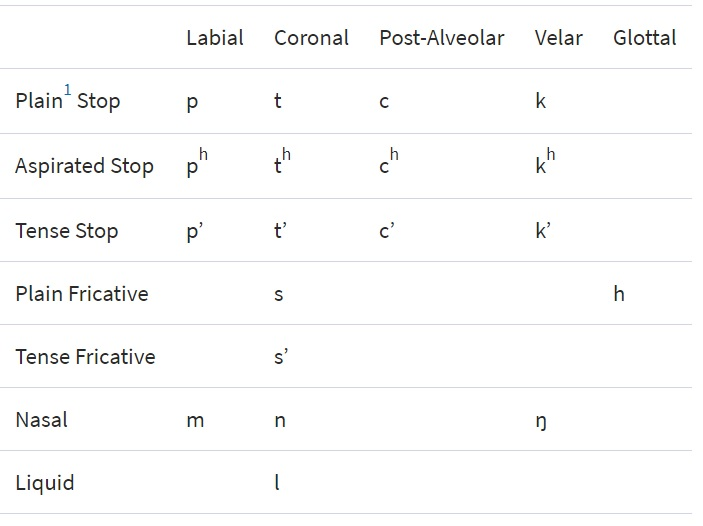

In [39]:
Image(filename="../media/korean_consonantal_inventory.jpg")

# (Yu Cho, 2016)

In [40]:
# minimal pairs for the three-way contrast in Korean stops

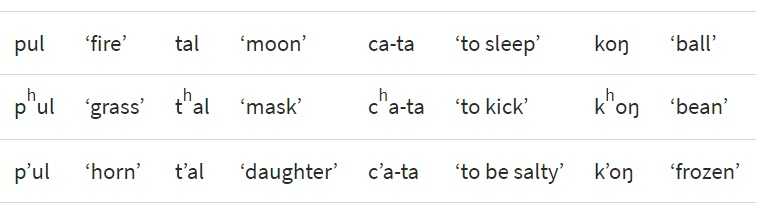

In [41]:
Image(filename="../media/phonation_contrasts_minimal_pairs.jpg")

# (Yu Cho, 2016)

In [42]:
# these recordings were made in 2014 with a 50 year old female native speaker of the Seoul dialect

In [43]:
# pul
Audio(filename="../media/불.mp3")

In [44]:
# pʰul
Audio(filename="../media/풀.mp3")

In [45]:
# pʼul
Audio(filename="../media/뿔.mp3")

In [46]:
# tal
Audio(filename="../media/달.mp3")

In [47]:
# tʰal
Audio(filename="../media/탈.mp3")

In [48]:
# tʼal
Audio(filename="../media/딸.mp3")

In [49]:
# ca (tsa)
Audio(filename="../media/자.mp3")

In [50]:
# cʰa (tsʰa)
Audio(filename="../media/차.mp3")

In [51]:
# cʼa (ts̕a)
Audio(filename="../media/짜.mp3")

In [52]:
# 

Word-medially, both tensification and aspiration of plain stops and fricatives occur:

In [53]:
# tensification

"When a plain plosive consonant (ㅂ \[p\], ㄷ \[t\], ㅈ \[ts\], ㄱ \[k\]) or the fricative consonant ㅅ \[s\] is preceded by a plosive or fricative consonant, it is reinforced to become a corresponding tense cosonant, as in 몇번 (sounding like 멷뻔 \[myʌt̚ p̕ʌn\] in careful speech or 며뻔 \[myʌ p̕ʌn\] in casual speech), 학생 (sounding like 학쌩) \[hak̚s̕ɛŋ\] and 없다 (sounding like 업따) \[ʌp̚t̕a\].... Tensification also occurs in compound nouns." (Cho et al., 2009, p. 36-37)

In [54]:
validate_model(integrated_korean["tensification"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation

학생 was in the training set. skipping.

☒ myʌt̚k̕wa            몇과            멷꽈             멷ᄁᄁ

식당 was in the training set. skipping.


학교 was in the training set. skipping.


숙제 was in the training set. skipping.


꽃집 was in the training set. skipping.


책상 was in the training set. skipping.

☒ pwep̚k̕et̚s̕ɯmɲida   뵙겠습니다      뵙껟씀니다       뵙끄ᄊ씀니다

없습니다 was in the training set. skipping.

☑ yʌrɯmbaŋhak̚         여름방학        여름방학         여름방학

길가 was in the training set. skipping.


강가 was in the training set. skipping.


봄비 was in the training set. skipping.

☑ myʌt̚ p̕ʌn           몇번            멷뻔             멷뻔
☒ myʌt̚ ɕik̕an         몇시간          멷시깐           멷ᄊ씨간
☒ nugu k̕ʌyeyo         누구거예요      누구꺼예요       누ᄀ구ᅥᅨᅨᅭ

This Data:
Perfect Accuracy:            33.33%
Syllable Accuracy:           47.62%
Segment (Letter) Accuracy:   75.47%

Cumulative:
Perfect Accuracy:            43.18%
Syllable Accuracy:       

In [55]:
# aspiration and ㅎ [h] weakening

"The fricative consonant ㅎ \[h\] is produced in the throat, soft palate, hard palate, or lips depending on the following vowel. When it is followed by a plain plosive cosonant (ㅂ \[p\], ㄷ \[t\], ㅈ \[ts\], ㄱ \[k\]), it merges with the consonant to produce the corresponding aspirate consonant (ㅍ \[pʰ\], ㅌ \[tʰ\], ㅊ \[tsʰ\], ㅋ \[kʰ\]), as in 좋다 (sounding like 조타) \[tsotʰa\] and 닫히다 (sounding like 다치다) \[tatsʰida\].... Between two voiced sounds (vowels, nasals, or ㄹ \[l\] consonants), ㅎ \[h\] tends to become silent in casual speech, as in 좋아요 (sounding like 조아요) \[tsoayo\] and 말한다 (sounding like 마란다) \[maranda\]." (Cho et al., 2009, p. 37-38)

In [56]:
validate_model(integrated_korean["aspiration_and_hieut_weakening"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation

좋다 was in the training set. skipping.


닫히다 was in the training set. skipping.

☒ tsokʰo               좋고            조코             조:ᅩ

입학 was in the training set. skipping.


많다 was in the training set. skipping.

☑ tsʰɛkʰago            책하고          채카고           채카고
☒ ɕidzakʰap̚ɕ̕ida      시작합시다      시자캅씨다       시자카ᅡ씨다
☒ ʌt̕ʌkʰe              어떻게          어떠케           어ᄄ떠ᄐ
☒ k̕otʰago             꽃하고          꼬타고           꼬차고
☒ tɛdapʰasʰeyo         대답하세요      대다파세요       대ᄃ다ᅡ퇴쇼
☒ tsoayo               좋아요          조아요           조ᄋᄋ요ᅭ
☒ malhanda             말한다          말한다           말:한ᅡᅡ

전화 was in the training set. skipping.

☑ yʌrɯmbaŋhak̚         여름방학        여름방학         여름방학
☒ sʰaraŋhanda          사랑한다        사랑한다         사랑한ᅡᅡ
☒ anɲyʌŋhasʰeyo        안녕하세요      안녕하세요       안녕텨되ᄉᄋ
☒ manayo               많아요          마나요           마:나요
☒ tsoas̕ʌyo            좋았어요        조아써요         조아어요
☒ tsalhɛs̕ʌyo   

In [57]:
#

In [58]:
# other types of sound change: assimilation and palatalization

In [59]:
#

In [60]:
# nasal assimilation (manner assimilation)

"All plosive and fricative consonants become the corresponding nasal consonants before a nasal consonant (ㅁ \[m\], ㄴ \[n\]). Notice that even ㅎ \[h\] is included in the change."

ㅂ, ㅍ \[p, pʰ\] → ㅁ \[m\]

ㄷ, ㅌ, ㅅ, ㅆ, ㅈ, ㅊ, ㅎ \[t, tʰ, s, sʼ, ts, tsʰ, h\] → ㄴ \[n\]

ㄱ, ㅋ, ㄲ \[k, kʰ, kʼ\] → ㅇ \[ŋ\]

(Cho et al., 2009, p. 36)

In [61]:
# NOTE: additional phenomena tested:
#       unrelease, tensification: "morɯget̚s̕ɯmɲida", "모르겠습니다", "모르겓씀니다"
#                                 "k̕ɯnnɛget̚s̕ɯmɲida", "끝내겠습니다", "끈내겓씀니다"

In [62]:
validate_model(integrated_korean["nasal_assimilation"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation

입만 was in the training set. skipping.


앞문 was in the training set. skipping.

☒ ʌmnayo               없나요          엄나요           엄:ᅡ아
☒ pannɯnda             받는다          반는다           반든다

끝나다 was in the training set. skipping.

☑ innɯnde              있는데          인는데           인는데
☑ nannɯnda             낳는다          난는다           난는다
☒ morɯget̚s̕ɯmɲida     모르겠습니다     모르겓씀니다     모르겓쓰니다
☒ hanguŋmallo          한국말로        한궁말로         한:궁망로
☑ hamɲik̕a             합니까          함니까           함니까
☒ k̕ɯnnɛget̚s̕ɯmɲida   끝내겠습니다     끈내겓씀니다     끔내걷씀니다
☑ myʌn ɲyʌn            몇년            면년             면년
☑ il haŋɲyʌn           일학년          일항년           일항년

This Data:
Perfect Accuracy:            50.00%
Syllable Accuracy:           75.00%
Segment (Letter) Accuracy:   80.65%

Cumulative:
Perfect Accuracy:            37.14%
Syllable Accuracy:           63.79%
Segment (Letter) Accuracy:   81.41%


In [63]:
# validate with more data

In [64]:
validate_model(introducing_phonology["nasalization"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation
☒ pam mani             밥많이          밤마니           밥마니
☒ pam mək-imyən        밥먹으면        밤머기면         밤머그문
☑ pam nəmu             밥너무          밤너무           밤너무
☒ pam nəkʰo            밥넣고          밤너코           밤너꼬

입어 was in the training set. skipping.

☑ imnɨnta              입는다          임는다           임는다

굽어 was in the training set. skipping.

☒ kumnɨnta             굽는다          굼는다           굼:ᅳᆫᆫᅡᅡ

접어 was in the training set. skipping.

☑ čəmnɨnta             접는다          점는다           점는다

닫아 was in the training set. skipping.

☑ tannɨnta             닫는다          단는다           단는다

붙어 was in the training set. skipping.

☑ punnɨnta             붙는다          분는다           분는다

쫓아 was in the training set. skipping.

☑ čonnɨnta             쫓는다          쫀는다           쫀는다

먹어 was in the training set. skipping.

☑ məŋnɨnta             먹는다          멍는다           멍는다

섞어 was in the training set. skipping.

☒ səŋ

In [65]:
# ㄴ [n] to ㄹ [l] assimilation (lateralization) (manner assimilation)

"When ㄹ \[l\] and ㄴ \[n\] come together, the ㄴ \[n\] sound is usually replaced by the ㄹ \[l\] sound, as in 칠 년: '칠련' \[tsʰil  lyʌn\]. When ㄹ \[l\] is followed by the vowel \[i\] ('이') or the semivowel 'y' (e.g., "야") in some compound words, another ㄹ \[l\] is inserted between them, as in 물약: '물략' \[muʎʎyak̚\]." (Cho et al., 2009, p. 36)

"A sequence of two coronal sonorants (/n+l/ or /l+n/) is not allowed regardless of their syllabic positions, resulting in bidirectional lateralization." (Yu Cho, 2016)

In [66]:
# NOTE: additional phenomena tested:
#       unrelease: "muʎʎyak̚", "물약", "물략"
#                  "sʰʌuʎʎyʌk̚", "서울역", "서울력"

In [67]:
validate_model(integrated_korean["rieul_assimilation"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation

물약 was in the training set. skipping.


진리 was in the training set. skipping.


신라 was in the training set. skipping.


전라도 was in the training set. skipping.


달님 was in the training set. skipping.


서울역 was in the training set. skipping.

☑ kirirɯm              길이름          기리름           기리름
☑ tsʰil  lyʌn          칠년            칠련             칠련
☑ pʰal lyʌn            팔년            팔련             팔련

This Data:
Perfect Accuracy:           100.00%
Syllable Accuracy:          100.00%
Segment (Letter) Accuracy:   100.00%

Cumulative:
Perfect Accuracy:            43.18%
Syllable Accuracy:           67.72%
Segment (Letter) Accuracy:   84.02%


In [68]:
# while it is important to not use training data to validate a model, setting the flag "skip_training_data" to False
# allows one to use all possible data when most of the data available has already been used to train the model. this
# allows a flawed but wider view of the model's performance. this was important here as the text used (Integrated Korean)
# appeared to differ in opinion with the tool developed by Busan National University: rather than an additional [l]
# segment being inserted in [kirirɯm], the [l] segement was simply delateralized. This differs from the behavior
# exhibited by the models with such items as [muʎʎyak̚] and [sʰʌuʎʎyʌk̚]

In [69]:
validate_model(integrated_korean["rieul_assimilation"], skip_training_data=False)

   IPA                Spelling        Pronunciation   Predicted Pronunciation
☒ muʎʎyak̚             물약            물략             무ᄅ략
☑ tsiʎʎi               진리            질리             질리
☒ ɕilla                신라            실라             실라ᅡ
☒ tsʌllado             전라도          절라도           절:ᅡ도
☑ taʎʎim               달님            달림             달림
☑ sʰʌuʎʎyʌk̚           서울역          서울력           서울력
☑ kirirɯm              길이름          기리름           기리름
☑ tsʰil  lyʌn          칠년            칠련             칠련
☑ pʰal lyʌn            팔년            팔련             팔련

This Data:
Perfect Accuracy:            66.67%
Syllable Accuracy:           80.95%
Segment (Letter) Accuracy:   96.43%

Cumulative:
Perfect Accuracy:            45.36%
Syllable Accuracy:           68.63%
Segment (Letter) Accuracy:   84.97%


In [70]:
# place assimilation

"In casual speech, ㄷ \[t\] is optionally pronounced ㅂ \[p\] before ㅂ \[p\] or ㅃ \[pʼ\] and as ㄱ \[k\] before ㄱ \[k\] or ㄲ \[kʼ\], as in 꽃병 (sounding like 꼳뼝/꼽뼝) \[k̕ot̚p̕yʌŋ/k̕opp̕yʌŋ\] and 갔고 (sounding like 갇꼬/각꼬) \[kat̚k̕o/kakk̕o\]. Similarly, ㄴ \[n\] is optionally pronounced ㅁ \[m\] before ㅂ \[p\], ㅃ \[pʼ\], or ㅁ \[m\], and ㅇ \[ŋ\] before ㄱ \[k\] or ㄲ \[kʼ\], as in 한미 (sounding like 한미/함미) \[hanmi/hammi\], 빗물 (sounding like 빈물/빔물) \[pinmul/pimmul\], and 한강 (sounding like 한강/항강) \[hangaŋ/haŋgaŋ\]." (Cho et al., 2009, p. 39)

"Coronals take on the place of the following non-coronal consonant." (Yu Cho, 2016)

In [71]:
# NOTE: no evidence of place assimilation appears in either the output from the model or the Busan National University tool.
#       perhaps this is due to the fact that neither of these seem to constitute casual speech

In [72]:
validate_model(integrated_korean["place_assimilation"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation

꽃병 was in the training set. skipping.

☑ kat̚k̕o              갔고            갇꼬             갇꼬

한미 was in the training set. skipping.


빗물 was in the training set. skipping.


한강 was in the training set. skipping.


옷감 was in the training set. skipping.


신문 was in the training set. skipping.


한국어 was in the training set. skipping.


젖병 was in the training set. skipping.


눈꺼풀 was in the training set. skipping.

☑ tat̚k̕o              닫고            닫꼬             닫꼬

꽃무늬 was in the training set. skipping.


밭갈이 was in the training set. skipping.


신발 was in the training set. skipping.

☑ ot̚ p̕allɛ           옷빨래          옫빨래           옫빨래

This Data:
Perfect Accuracy:           100.00%
Syllable Accuracy:          100.00%
Segment (Letter) Accuracy:   100.00%

Cumulative:
Perfect Accuracy:            47.00%
Syllable Accuracy:           69.33%
Segment (Letter) Accuracy:   85.33%


In [73]:
# use training data again, just to verify whether or not model seemed to acquire any place assimilation knowledge

In [74]:
validate_model(integrated_korean["place_assimilation"], skip_training_data=False)

   IPA                Spelling        Pronunciation   Predicted Pronunciation
☑ k̕ot̚p̕yʌŋ           꽃병            꼳뼝             꼳뼝
☑ kat̚k̕o              갔고            갇꼬             갇꼬
☑ hanmi                한미            한미             한미
☑ pinmul               빗물            빈물             빈물
☒ hangaŋ               한강            한강             한:강
☑ ot̚k̕am              옷감            옫깜             옫깜
☑ ɕinmun               신문            신문             신문
☒ hangugʌ              한국어          한구거           한:구거
☑ tsʌt̚p̕yʌŋ           젖병            젇뼝             젇뼝
☑ nunk̕ʌpʰul           눈꺼풀          눈꺼풀           눈꺼풀
☑ tat̚k̕o              닫고            닫꼬             닫꼬
☑ k̕onmuɲi             꽃무늬          꼰무니           꼰무니
☑ pat̚k̕ari            밭갈이          받까리           받까리
☑ ɕinbal               신발            신발             신발
☑ ot̚ p̕allɛ           옷빨래          옫빨래           옫빨래

This Data:
Perfect Accuracy:            86.67%
Syllable Accuracy:           91.43%
Segment (Letter)

In [75]:
# palatalization

"When a (syllable) ending in ㄷ \[t\] or ㅌ \[tʰ\] is followed by a suffix beginning with the vowel "i" \[i\] or the semivowel "y" (whether ㅎ \[h\] intervenes or not), the ㄷ \[t\] and ㅌ \[tʰ\] are pronounced ㅈ \[ts\] and ㅊ \[tsʰ\], respectively, as in 닫혀요 (sounding like 다쳐요) \[tatsʰyʌyo\] and 붙이다 (sounding like 부치다) \[putsʰida\]. This change is technically called "palatalization" because the original gum-ridge consonants are articulated in the area of the hard palate." (Cho et al., 2009, p. 38-39)

"Palatalization is a phenomenon where dental stops /t, tʰ/ are realized as prepalatal affricates \[ts, tsʰ\] when followed by an /i/ or /y/ across a morpheme boundary, one of the prime cases of nonderived environment blocking (NDEB). Palatalization is blocked in underived forms.... Palatalization is (also) blocked across... compounds... and between larger units." (Yu Cho, 2016)

In [76]:
validate_model(integrated_korean["palatalization"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation
☑ tatsʰyʌyo            닫혀요          다쳐요           다쳐요

붙이다 was in the training set. skipping.

☒ putsʰyʌyo            붙여요          부쳐요           분ᄂ요

같이 was in the training set. skipping.


밑이 was in the training set. skipping.


This Data:
Perfect Accuracy:            50.00%
Syllable Accuracy:           66.67%
Segment (Letter) Accuracy:   83.33%

Cumulative:
Perfect Accuracy:            52.14%
Syllable Accuracy:           71.47%
Segment (Letter) Accuracy:   86.10%


In [77]:
# validate with more data

# NOTE:

# [tsʰʌdinsʰaŋi] is a compound and should not exhibit palatalization. It should also not exhibit resyllabification.

# 밭이랑 has two meanings: "with a field" and "the furrow(s) of a field". The compound word [pat̚iraŋ] should not
# exhibit palatalization while the other should.

# [pat̚ilgwʌ] forms a larger phrasal unit meaning "cultivate a field" and should not exhibit palatalization.

In [78]:
validate_model(korean_phonology["palatalization"])

   IPA                Spelling        Pronunciation   Predicted Pronunciation
☒ tsʰʌdinsʰaŋi         첫인상이        처딘상이         처신상이

밭이 was in the training set. skipping.

☑ patsʰida             밭이다          바치다           바치다
☒ patsʰiraŋ            밭이랑          바치랑           반니ᅡᅡᆼ
☒ pat̚iraŋ             밭이랑          받이랑           반니ᅡᅡᆼ
☒ pat̚ilgwʌ            밭일궈          받일궈           반ᅵᆯ궈

This Data:
Perfect Accuracy:            20.00%
Syllable Accuracy:           37.50%
Segment (Letter) Accuracy:   64.10%

Cumulative:
Perfect Accuracy:            50.82%
Syllable Accuracy:           70.00%
Segment (Letter) Accuracy:   85.14%


In [79]:
# 

# References

Cho, Y., Lee, H. S., Schulz, C., Sohn, H., & Sohn, S. (2009). Integrated Korean: Beginning 1 (Klear Textbooks in Korean Language). University of Hawaii Press.

Crystal, D. (2008). A Dictionary of Linguistics and Phonetics. Oxford: Blackwell Publishing.

Yu Cho, Y.  (2016, October 26). Korean Phonetics and Phonology. Oxford Research Encyclopedia of Linguistics. Retrieved 15 Apr. 2021, from https://oxfordre.com/linguistics/view/10.1093/acrefore/9780199384655.001.0001/acrefore-9780199384655-e-176.